In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [297]:
ses = 2
sessions = {
    '1':'FP1',
    '2':'FP2',
    '3':'FP3'
}


In [41]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

In [95]:
session = fastf1.get_session(2023,11,sessions[str(ses)])
session.load()


core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v2.3.1]
api            INFO 	Fetching driver list...
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .ite

### Pre defined

In [357]:
compound_color = {'HARD': '#F0F0EC', 
                  'INTERMEDIATE': '#43B02A', 
                  'MEDIUM': '#FFD12E', 
                  'SOFT': '#DA291C', 
                  'TEST-UNKNOWN': '#434649', 
                  'UNKNOWN': '#00FFFF', 
                  'WET': '#0067AD'}
compound = ['All Compounds','SOFT','MEDIUM','HARD']

### Code Start

In [358]:
def max_lap(laps):
    grouped = laps.groupby("Driver")
    count_values = grouped['LapNumber'].count()
    return count_values.max()

# 
laps = session.laps.pick_wo_box()
max_lap = int(max_lap(laps)+1)
max_lap_time = int(session.laps["LapTime"].dt.total_seconds().max())
drivers = session.drivers
comp = 0

In [359]:
# laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
# laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")


In [360]:
if(comp == 0):
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime","TyreLife","Stint"]]
    laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
    laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
    laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

else:
    laps_session = laps.loc[(laps["Compound"] == compound[comp]),["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime","TyreLife","Stint"]]
    laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
    laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
    laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\4055197875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\4055197875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\4055197875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [361]:
list_comp_color = []
for index,lap in laps_session.iterrows():
    list_comp_color.append(compound_color[lap["Compound"]])
laps_session["CompoundColor"] = list_comp_color

C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\2004088471.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_session["CompoundColor"] = list_comp_color


In [362]:
max_lap_time = int(laps_session.loc[laps_session["LapTimeS"] <= 90,["LapTimeS"]].max()+3)
min_lap_time = int(laps_session["LapTimeS"].min()-1)

### Graph Pace Practice

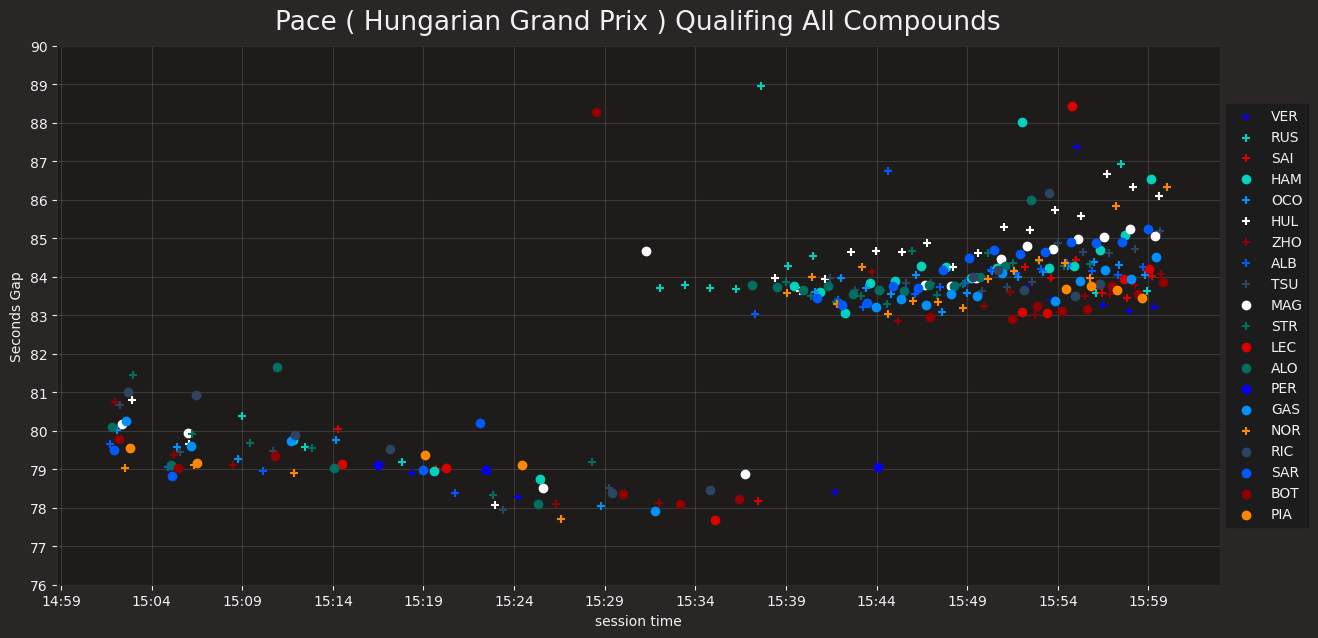

In [363]:
plt.figure(figsize=(15, 7))
color_picked = []
# for i in drivers[:10]:
for i in drivers:
    lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    lap_ordred = lap_ordred.loc[lap_ordred["LapTimeS"] <= 90]
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('Pace ( '+session.event["EventName"]+' ) Qualifing' +" "+compound[comp])
plt.xlabel('session time')
plt.ylabel('Seconds Gap')

plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


### Table pace 

In [364]:
data_time = pd.DataFrame()
data_time ["lapNumber"] = [i for i in range(1, max_lap+1)]
data_comp = pd.DataFrame()
data_comp ["lapNumber"] = [i for i in range(1, max_lap+1)]

In [365]:
for i in drivers:
    data_time [session.get_driver(i)['Abbreviation']] = laps.loc[laps["DriverNumber"]==i,["LapTimeMinute"]].reset_index(drop=True)
    data_comp [session.get_driver(i)['Abbreviation']] = laps.loc[laps["DriverNumber"]==i,["Compound"]].reset_index(drop=True)

In [366]:
# df = pd.DataFrame(data_time)

# df.to_excel('Session_lap_time.xlsx', index=False)
# # Charger le fichier Excel existant
# fichier_excel = 'Session_lap_time.xlsx'
# classeur = load_workbook(fichier_excel)

# # Sélectionner la feuille active
# feuille = classeur.active

# for j in range(1,data_time.shape[1]):
#     for i in range(0,data_time.shape[0]):
#         compound = data_comp.iloc[i,j]
#         if(compound == "HARD"):
#             couleur = compound_color["HARD"]
#         elif(compound == "MEDIUM"):
#             couleur = compound_color["MEDIUM"]
#         elif(compound == "SOFT"):
#             couleur = compound_color["SOFT"]
#         else:
#             couleur = 'FFFFFF'
#         cellule = feuille.cell(row=i+2, column=j+1)
#         cellule.fill = PatternFill(start_color=couleur, end_color=couleur, fill_type='solid')

# # Enregistrer les modifications dans le fichier Excel
# classeur.save(fichier_excel)

### Top Speed in session

In [367]:
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []
df_top_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        Top_Speed = max_speed.loc[max_speed['Speed'].idxmax(),"Speed"]
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        top_speed_list.append(Top_Speed)
        color_list.append(TeamColor)
df_top_speed["DriverNumber"] = driver_list
df_top_speed["Driver"] = DriverAB_list
df_top_speed["TopSpeed"] = top_speed_list
df_top_speed["Color"] = color_list
df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False)


c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` 

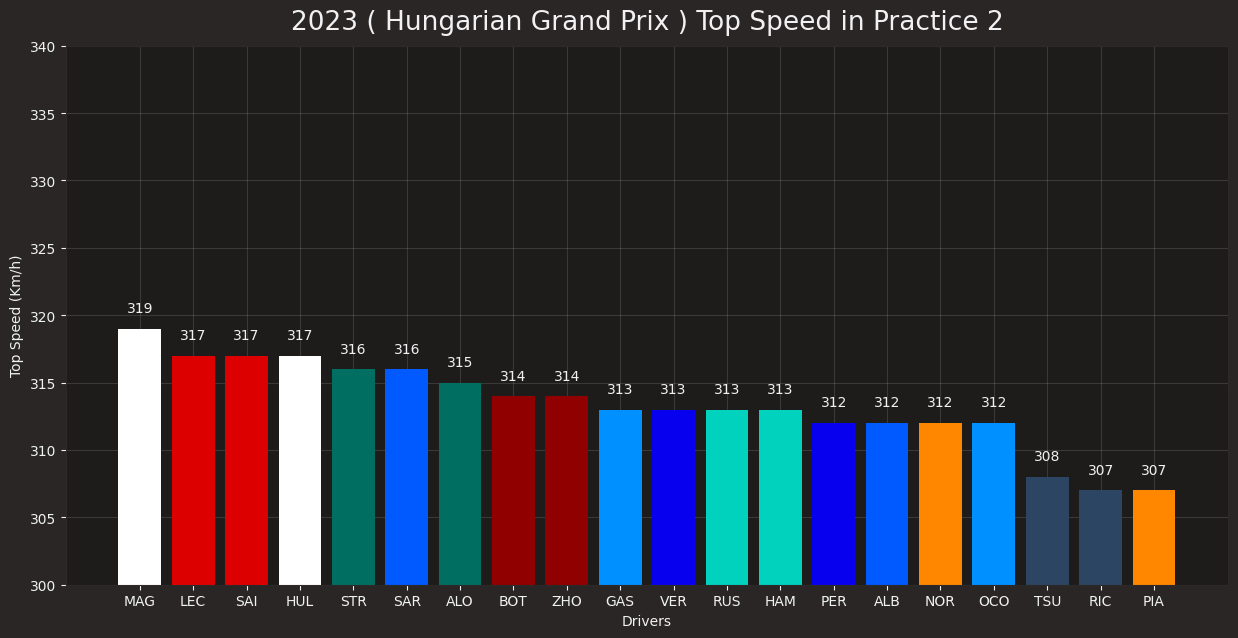

In [368]:
plt.figure(figsize=(15, 7))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Top Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) Top Speed in '+session.event["Session2"])
plt.yticks(range(300, 400, 5))
plt.ylim(300, 340)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+1, str(y.loc[i]), ha='center', va='bottom')
    
plt.grid(True, alpha=0.2)
# Display the plot
plt.show()

### averege Speed in fastest lap

In [369]:
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []
df_avg_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        avg_Speed = round(max_speed["Speed"].mean())
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        avg_speed_list.append(avg_Speed)
        color_list.append(TeamColor)
df_avg_speed["DriverNumber"] = driver_list
df_avg_speed["Driver"] = DriverAB_list
df_avg_speed["AvgSpeed"] = avg_speed_list
df_avg_speed["Color"] = color_list
df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False)


c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` 

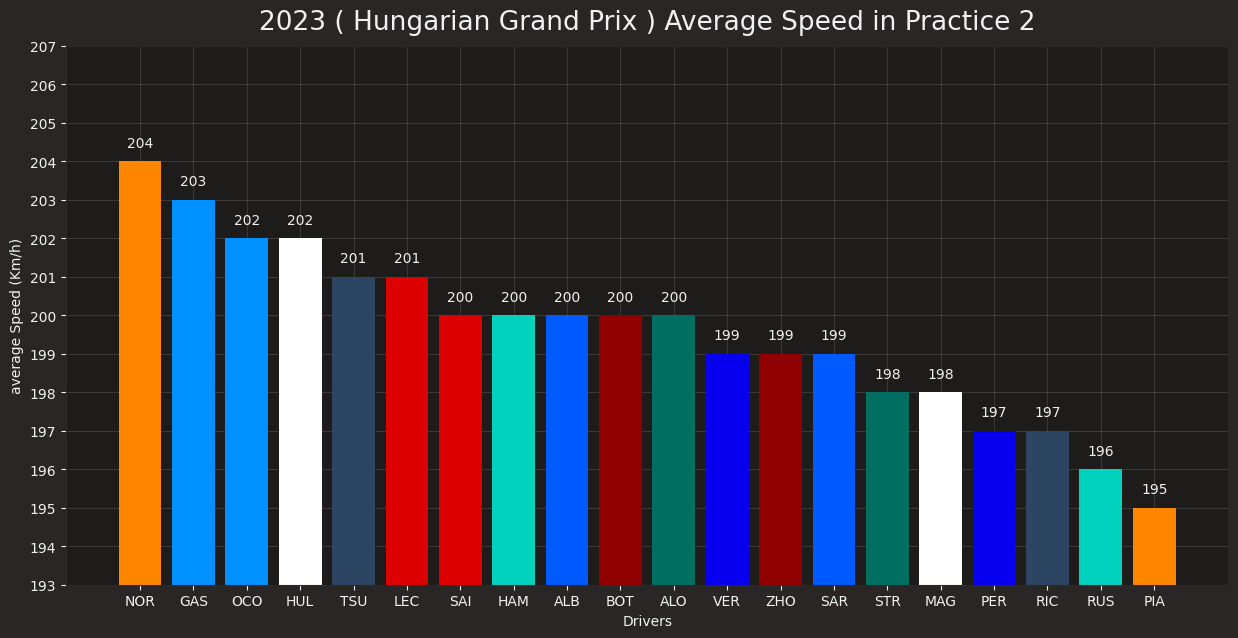

In [370]:
plt.figure(figsize=(15, 7))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) Average Speed in Practice '+str(ses))
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(True, alpha=0.2)

# Display the plot
plt.show()

### gap fastest lap 

In [371]:
laps["LapTimeS"] = laps["LapTime"].dt.total_seconds()

C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\3128682134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeS"] = laps["LapTime"].dt.total_seconds()


In [372]:
# pd.DataFrame(laps.pick_driver(1).pick_fastest()).T.reset_index(drop=True)

In [373]:
team_color = []
fastest_lap = pd.DataFrame(laps.pick_driver(1).pick_fastest()).T.reset_index(drop=True)
fastest_lap = fastest_lap.drop(0)
for i in drivers:
    fastlap = pd.DataFrame(laps.pick_driver(i).pick_fastest()).T.reset_index(drop=True)
    if (fastlap.isnull().all(axis=1).all()== False):
        fastest_lap = pd.concat([fastest_lap,fastlap ], ignore_index=True)
        team_color.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))
fastest_lap["LapTimeS"].fillna(0, inplace=True)
fastest_lap["TeamColor"] = team_color

In [374]:
fastest_lap = fastest_lap.sort_values(by='LapTimeS').reset_index(drop=True)

In [375]:
# fastest_lap[["DriverNumber","Driver","LapTimeMinute","LapTimeS","TeamColor"]]
fastest_lap["Gap"] = fastest_lap["LapTimeS"]-fastest_lap["LapTimeS"].min()

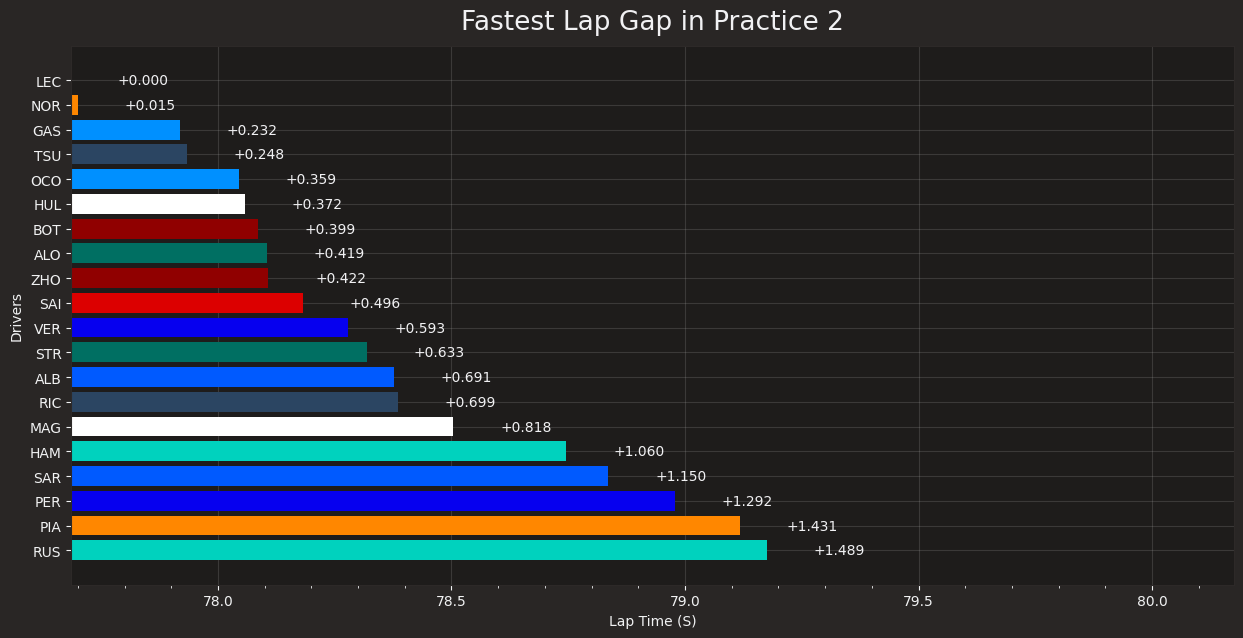

In [376]:
plt.figure(figsize=(15, 7))

y = fastest_lap["Driver"]
x = fastest_lap["LapTimeS"]
minx = fastest_lap["LapTimeS"].min()
maxx = fastest_lap["LapTimeS"].max()
# Create the horizontal bar plot
plt.barh(y,x , color = fastest_lap["TeamColor"])

# Set labels and title
plt.xlabel('Lap Time (S)')
plt.ylabel('Drivers')
plt.title('Fastest Lap Gap in Practice '+str(ses))
plt.xticks(range(80, 95, 1))
plt.xlim(minx, maxx+1)
plt.gca().invert_yaxis()
# Set the y-axis ticker to display integer values with increments of 0.1
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

plt.grid(True,alpha = 0.2)


# Add text annotations near each bar
for i in range(0,len(y)):
    plt.text(fastest_lap["LapTimeS"][i] + 0.1, i, "+"+"{:.3f}".format(fastest_lap["Gap"][i]), va='center')

# Display the plot
plt.show()

In [377]:
table_results = fastest_lap[["Driver","Sector1Time","Sector2Time","Sector3Time","LapTime","Gap"]]

In [378]:
def highlight_min(s):
    is_min = s == s.min()
    return ['color: purple' if v else '' for v in is_min]

# Apply the styling using apply()
styled_df = table_results.style.apply(highlight_min, subset=['Sector1Time','Sector2Time','Sector3Time','LapTime'])
# Define the CSS styling for the header
header_styles = [
    {'selector': 'th',
     'props': [('background-color', 'purple'), ('color', 'white')]}
]

# Apply the header styling using set_table_styles()
# styled_df = table_results.style.set_table_styles(header_styles)
styled_df

,Driver,Sector1Time,Sector2Time,Sector3Time,LapTime,Gap
0,LEC,0 days 00:00:28.076000,0 days 00:00:27.444000,0 days 00:00:22.166000,0 days 00:01:17.686000,0.000000
1,NOR,0 days 00:00:28.021000,0 days 00:00:27.419000,0 days 00:00:22.261000,0 days 00:01:17.701000,0.015000
2,GAS,0 days 00:00:27.976000,0 days 00:00:27.838000,0 days 00:00:22.104000,0 days 00:01:17.918000,0.232000
3,TSU,0 days 00:00:28.311000,0 days 00:00:27.454000,0 days 00:00:22.169000,0 days 00:01:17.934000,0.248000
4,OCO,0 days 00:00:28.143000,0 days 00:00:27.545000,0 days 00:00:22.357000,0 days 00:01:18.045000,0.359000
5,HUL,0 days 00:00:27.959000,0 days 00:00:27.752000,0 days 00:00:22.347000,0 days 00:01:18.058000,0.372000
6,BOT,0 days 00:00:28.249000,0 days 00:00:27.539000,0 days 00:00:22.297000,0 days 00:01:18.085000,0.399000
7,ALO,0 days 00:00:28.057000,0 days 00:00:27.468000,0 days 00:00:22.580000,0 days 00:01:18.105000,0.419000
8,ZHO,0 days 00:00:28.306000,0 days 00:00:27.513000,0 days 00:00:22.289000,0 days 00:01:18.108000,0.422000
9,SAI,0 days 00:00:28.047000,0 days 00:00:27.855000,0 days 00:00:22.280000,0 days 00:01:18.182000,0.496000


In [379]:
# 1. Graphique en radar : Utilisez un graphique en radar pour représenter les performances des pilotes dans différents secteurs du circuit. 
# Chaque axe représente un secteur du circuit et la distance depuis le centre du graphique indique les temps au tour. 
# Cela permet de visualiser les forces et les faiblesses de chaque pilote dans les différents secteurs du circuit.

# 2. Graphique en nuages de points : Tracez les temps au tour en fonction de la vitesse maximale atteinte pour chaque pilote. 
# Cela permet de déterminer s il existe une corrélation entre la vitesse maximale et les temps au tour.

# 3. Heatmap : Créez une heatmap qui représente les temps au tour pour chaque pilote sur une grille en fonction des secteurs du circuit. 
# Cela permet de visualiser les variations des temps au tour dans différents secteurs.

### 2. Graphique en nuages de points : Tracez les temps au tour en fonction de la vitesse maximale atteinte pour chaque pilote. 
##### Cela permet de déterminer s il existe une corrélation entre la vitesse maximale et les temps au tour.

In [380]:
quick_laps = laps.pick_quicklaps()

top_speed_list = []
for index,lap in quick_laps.iterrows():
    top_speed_list.append(lap.get_car_data().max()["Speed"])
quick_laps["TopSpeed"] = top_speed_list

C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\4211554812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quick_laps["TopSpeed"] = top_speed_list


In [381]:
quick_laps = quick_laps[["DriverNumber","Driver","LapNumber","LapTimeS","TopSpeed"]]

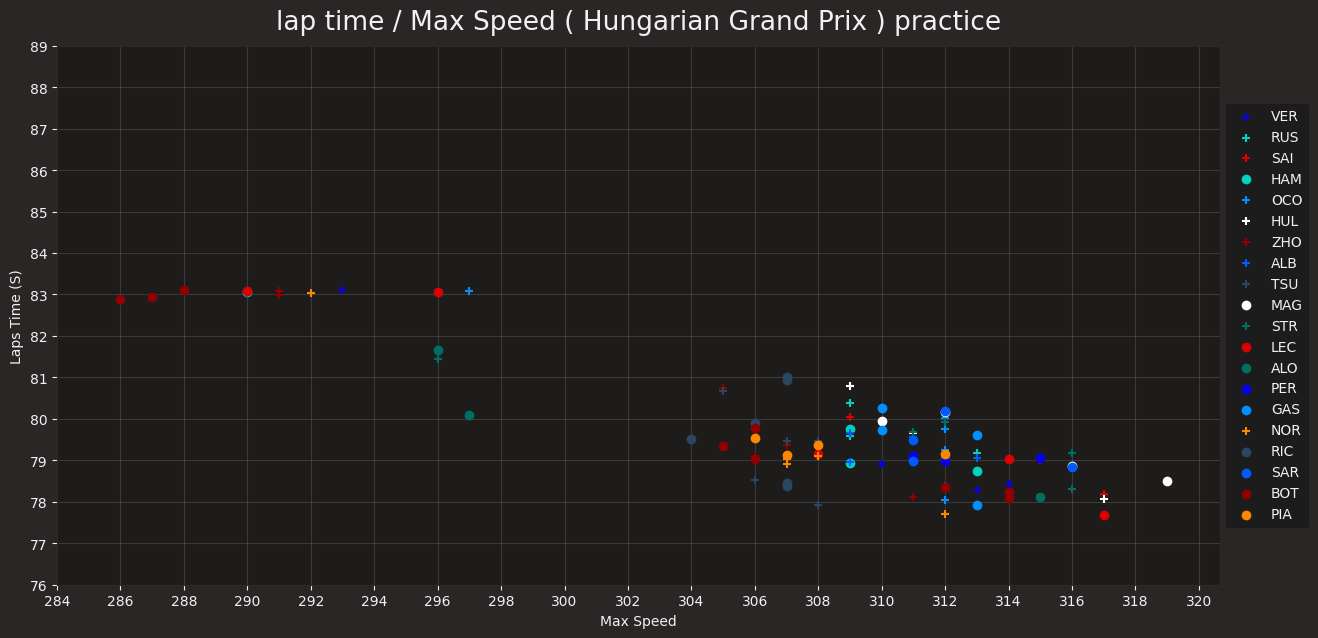

In [382]:
plt.figure(figsize=(15, 7))
color_picked = []
# for i in drivers[:10]:
for i in drivers:
    quick_laps_driver = quick_laps.loc[quick_laps["DriverNumber"] == i].reset_index(drop=True)
    x = quick_laps_driver["TopSpeed"]
    y = quick_laps_driver["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)


# Customize the plot
plt.title('lap time / Max Speed ( '+session.event["EventName"]+' ) practice')
plt.xlabel('Max Speed')
plt.ylabel('Laps Time (S)')

plt.xticks(range(quick_laps["TopSpeed"].min()-2, quick_laps["TopSpeed"].max()+2, 2))
plt.yticks(range(min_lap_time, 90, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

### 2. Graphique en nuages de points : Tracez les temps au tour en fonction de la vitesse minimal atteinte pour chaque pilote. 
##### Cela permet de déterminer s il existe une corrélation entre la vitesse Minimal et les temps au tour.

In [383]:
quick_laps = laps.pick_quicklaps()

top_speed_list = []
for index,lap in quick_laps.iterrows():
    top_speed_list.append(lap.get_car_data().min()["Speed"])
quick_laps["TopSpeed"] = top_speed_list

C:\Users\GTR\AppData\Local\Temp\ipykernel_16796\1954535122.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quick_laps["TopSpeed"] = top_speed_list


In [384]:
quick_laps = quick_laps[["DriverNumber","Driver","LapNumber","LapTimeS","TopSpeed"]]

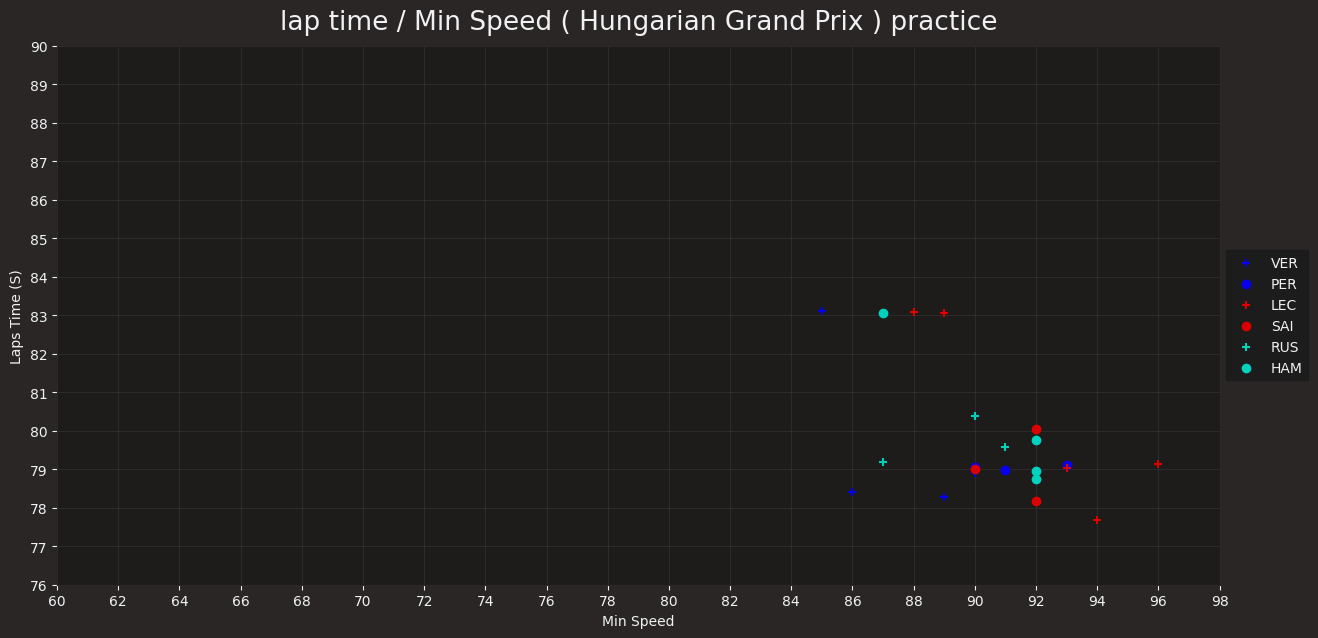

In [385]:
plt.figure(figsize=(15, 7))
color_picked = []
# for i in drivers[:10]:
for i in ['1','11','16','55','63','44']:
    quick_laps_driver = quick_laps.loc[quick_laps["DriverNumber"] == i].reset_index(drop=True)
    x = quick_laps_driver["TopSpeed"]
    y = quick_laps_driver["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)


# Customize the plot
plt.title('lap time / Min Speed ( '+session.event["EventName"]+' ) practice')
plt.xlabel('Min Speed')
plt.ylabel('Laps Time (S)')

plt.xticks(range(60, 100, 2))
plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.1)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

### Race pace compareson 

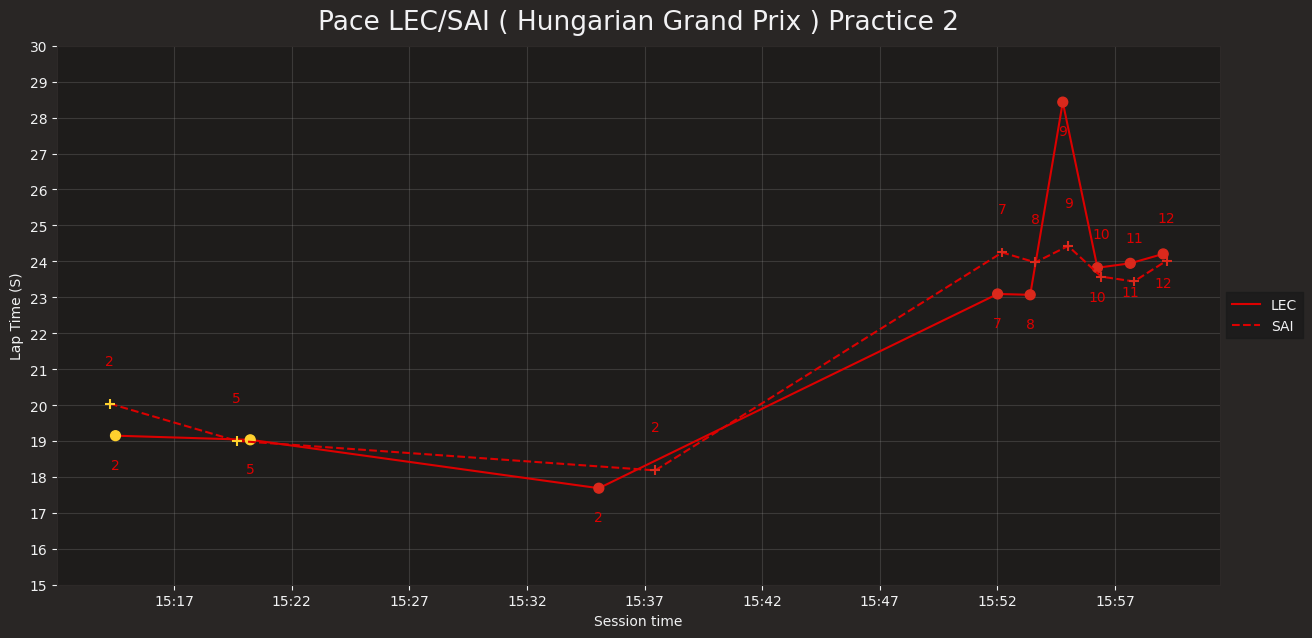

In [408]:
plt.figure(figsize=(15, 7))
color_picked = []
# for i in drivers[:10]:
drivers_list = ['16','55']
z = 1
session_time = pd.to_datetime('2023-07-21 15:00:00.000')
for i in drivers_list:
    lap_ordred = laps_session.loc[(laps_session["DriverNumber"] == i)&(laps_session["LapStartDate"] >= session_time)].sort_values(by='LapStartDateM', ascending=True)
    # lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    lap_ordred["LapTimeS"] = lap_ordred["LapTimeS"] - 60
    lap_ordred = lap_ordred.loc[lap_ordred["LapTimeS"] <= 30]
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]
    
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    marker_color = lap_ordred["CompoundColor"]
    z = z*-1
    if team_color in color_picked:
        plt.plot(x, y, color=team_color, label=driver_name, linestyle='--')
        plt.scatter(x, y, color=marker_color, marker='+', s=50, zorder=2)
        # Add numeric values above each marker
        for xi, yi, label in zip(x, y+z, lap_ordred["TyreLife"]):
            plt.text(xi, yi, str(int(label)), ha='center', va='bottom', color=team_color)
    else:    
        plt.plot(x, y, color=team_color, label=driver_name)
        plt.scatter(x, y, color=marker_color, marker='o', s=50, zorder=2)   
        # Add numeric values above each marker
        for xi, yi, label in zip(x, y+z, lap_ordred["TyreLife"]):
            plt.text(xi, yi, str(int(label)), ha='center', va='bottom', color=team_color)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('Pace '+session.get_driver(drivers_list[0])["Abbreviation"]+'/'+session.get_driver(drivers_list[1])["Abbreviation"]+' ( '+session.event["EventName"]+' ) Practice 2')
plt.xlabel('Session time')
plt.ylabel('Lap Time (S)')

plt.yticks(range(0,max_lap_time, 1))
plt.ylim(15,30)



plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()
